# Introduction

This notebook aims at discovering Convolutional Neural Network. We will see the theory behind it, and an implementation in Pytorch for hand-digits classification on MNIST dataset. 

# History

Contrary to what most people think, Neural Networks is quite an old concept. It was first introduced in 1957 under the name ***perceptron***. Peceptron is a 1-layer feed forward neural network. However the infrastructure and the algorthm around it was not good enough to allow large scale training. Later on in 1986, ***Multi Layer Perceptron (MLP)*** was introduced with the backpropagation algorithm in order to train a network with more than 1 layer. Thanks to this algorithm we are not able to train non-linear model which can learn high level abstract features. Then ***Convolutional Neural Network (CNN)*** has been introduced in order to learn better features and with the possibility to reduce the number of parameters to be trained. And now, here we are, in the ***Deep Learning era*** 

    # Multi-Layer Perceptron

The first thing to ask is : why do we needed Convolutional Neural Network in the first place... Well, let's see what happen when we train a Multi-Layer Perceptron to recognize hand-written digits. In Machine Learning we have our own "Hello World" which is the MNIST dataset. Let's see what this dataset is about and how a multi-layer perceptron will perform.   

In [2]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

In [3]:
data = np.load('Data/data_train.npy').T
X_og = data.copy()[:500,:]/255
y =np.loadtxt('Data/correct_labels.npy')[:500]

FileNotFoundError: [Errno 2] No such file or directory: 'Data/data_train.npy'

In [ ]:
print(X_og)

[[0.63137255 0.63529412 0.63529412 ... 0.58431373 0.58431373 0.57647059]
 [0.63529412 0.63529412 0.63529412 ... 0.64705882 0.64705882 0.64705882]
 [0.76470588 0.76470588 0.76470588 ... 0.74901961 0.74901961 0.74901961]
 ...
 [0.63529412 0.63921569 0.62352941 ... 0.63137255 0.63529412 0.61960784]
 [0.64705882 0.61568627 0.64313725 ... 0.63137255 0.63137255 0.61960784]
 [0.80784314 0.80784314 0.80784314 ... 0.75686275 0.75686275 0.75686275]]


In [ ]:
y = y.astype(float).astype(int)
print(y)

[8 8 1 3 8 6 1 8 6 3 9 4 4 2 4 2 3 6 6 9 0 1 7 2 2 9 8 3 8 0 2 0 3 2 7 0 7
 6 8 3 8 5 9 1 6 3 4 7 0 3 3 4 7 6 2 0 1 0 4 0 1 1 9 2 7 6 1 0 9 4 6 6 5 4
 0 3 5 1 8 1 9 0 2 0 9 5 3 5 9 6 9 9 8 6 7 2 1 5 7 4 2 0 6 3 0 3 2 1 6 5 9
 6 2 4 7 9 0 3 0 5 3 6 3 3 0 2 7 5 4 3 2 5 8 1 8 2 9 9 2 1 8 7 1 8 1 4 4 1
 8 6 9 4 1 9 8 0 4 2 7 7 4 2 3 3 7 8 4 0 9 9 4 4 0 5 0 4 4 4 9 5 9 9 4 2 7
 2 8 7 8 9 3 5 2 6 7 2 5 7 8 0 3 0 0 4 6 5 6 6 8 8 3 9 2 1 7 2 2 1 3 2 1 0
 0 5 4 3 3 0 7 6 3 0 5 7 1 2 0 9 9 1 0 8 8 9 7 6 8 6 4 0 7 6 0 9 1 2 6 7 3
 9 4 1 3 5 0 6 9 7 8 6 5 6 5 8 2 8 2 3 1 9 9 3 1 8 1 7 4 5 1 4 2 5 5 3 6 0
 4 2 2 8 0 1 0 5 7 9 9 1 0 5 8 5 3 3 6 0 1 4 7 4 4 5 8 2 1 0 9 2 9 2 8 4 8
 4 5 9 2 4 8 4 2 0 9 3 8 3 5 7 0 6 8 2 7 7 7 5 9 7 2 2 9 8 5 8 6 7 0 3 0 9
 0 6 4 2 3 9 3 3 1 1 2 7 3 3 0 5 1 4 0 7 8 0 5 9 5 0 8 5 1 3 0 8 1 7 6 0 6
 3 2 8 7 8 2 7 2 3 5 0 3 9 9 6 3 5 8 8 5 3 2 7 8 2 7 2 2 7 9 5 5 5 7 4 8 0
 7 7 6 7 4 9 8 1 5 6 3 6 5 3 3 4 3 8 1 8 1 3 0 6 4 0 0 2 3 5 7 8 8 7 2 2 2
 1 1 0 5 5 6 1 1 1 8 6 9 

In [ ]:
print(np.shape(X_og))
print(np.shape(y))

(500, 90000)
(500,)


In [ ]:
X = 1-X_og.copy()
def resize_func(input_data,new_width,new_height):#input the (1,90000) data
    size1 = np.shape(input_data)[0]
    size2 = int(size1**(0.5))
    output = cv2.resize(input_data.reshape(size2,size2),(new_width,new_height))
    return output
def morph_ops(input_data):
    dilate_kernel = np.ones((2,2),np.uint8)
    open_kernel = np.ones((3,3),np.uint8)
    closed_kernel = np.ones((3,3),np.uint8)
    d2_kernel = np.ones((3,3),np.uint8)
    gradient_kernel = np.ones((3,3),np.uint8)
    open2_kernel = np.ones((3,3),np.uint8)
    picture = resize_func(input_data,28,28)
    dilated_picture = cv2.dilate(picture,dilate_kernel,iterations=1)
    opened_picture = cv2.morphologyEx(dilated_picture,cv2.MORPH_OPEN,open_kernel)
    # closed_picture = cv2.morphologyEx(opened_picture,cv2.MORPH_CLOSE,closed_kernel)
    # d2_picture = cv2.dilate(closed_picture,d2_kernel,iterations=1)
    # gradient_picture = cv2.morphologyEx(d2_picture,cv2.MORPH_GRADIENT,gradient_kernel)
    # open2_picture = cv2.morphologyEx(gradient_picture,cv2.MORPH_OPEN,open2_kernel)
    return picture
    #return opened_picture
    #return open2_picture

X_new = np.zeros((np.shape(X_og)[0],28*28))
print(np.shape(X_og))
print(np.shape(X_new))
for ii in range(np.shape(X_new)[0]):
    newrow = morph_ops(X_og[ii,:])
    newrow = newrow.reshape(1,-1)
    newrow = resize_func(newrow[0,:],28,28)
    newrow = newrow.reshape(1,-1)
    X_new[ii,:] = newrow
print(np.shape(X_new))
X = X_new
X = 1-X

(500, 90000)
(500, 784)
(500, 784)


In [1]:
index = 0
x1 = X[index,:].reshape(28,28)
plt.imshow(x1,cmap='gray')
print(y[index])
plt.imshow

NameError: name 'X' is not defined

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_og, y, test_size=0.2)

In [47]:
BATCH_SIZE = 200

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor) # data type is long

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)


In [48]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(300*300,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1)
 
mlp = MLP()
print(mlp)


MLP(
  (linear1): Linear(in_features=90000, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)


We have 784\*(250+1) + 250\*(100+1) + 100\*(10+1) = 222 360 parameters to train

In [49]:
def fit(model, train_loader):
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)#,lr=0.001, betas=(0.9,0.999))
    error = nn.CrossEntropyLoss()
    EPOCHS = 25
    model.train()
    lossvec = []
    for epoch in range(EPOCHS):
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            lossvec.append(loss.item())
            optimizer.step()

            # Total correct predictions
            #predicted = torch.max(output.data,0)[1]
            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            #print(correct)
            if batch_idx % 100 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.item(), float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))
    return lossvec
                

In [50]:
loss_vec = fit(mlp, train_loader)

Epoch : 0 [0/400 (0%)]	Loss: 2.300048	 Accuracy:8.500%
Epoch : 1 [0/400 (0%)]	Loss: 2.294019	 Accuracy:9.000%
Epoch : 2 [0/400 (0%)]	Loss: 2.289717	 Accuracy:9.500%
Epoch : 3 [0/400 (0%)]	Loss: 2.286657	 Accuracy:10.500%
Epoch : 4 [0/400 (0%)]	Loss: 2.283544	 Accuracy:10.500%
Epoch : 5 [0/400 (0%)]	Loss: 2.278671	 Accuracy:11.500%
Epoch : 6 [0/400 (0%)]	Loss: 2.275891	 Accuracy:12.000%
Epoch : 7 [0/400 (0%)]	Loss: 2.274209	 Accuracy:13.000%
Epoch : 8 [0/400 (0%)]	Loss: 2.275174	 Accuracy:13.500%
Epoch : 9 [0/400 (0%)]	Loss: 2.269042	 Accuracy:14.000%
Epoch : 10 [0/400 (0%)]	Loss: 2.266500	 Accuracy:14.000%
Epoch : 11 [0/400 (0%)]	Loss: 2.264361	 Accuracy:14.500%
Epoch : 12 [0/400 (0%)]	Loss: 2.262258	 Accuracy:14.500%
Epoch : 13 [0/400 (0%)]	Loss: 2.259307	 Accuracy:15.000%
Epoch : 14 [0/400 (0%)]	Loss: 2.257141	 Accuracy:15.000%
Epoch : 15 [0/400 (0%)]	Loss: 2.254734	 Accuracy:15.000%
Epoch : 16 [0/400 (0%)]	Loss: 2.252542	 Accuracy:15.000%
Epoch : 17 [0/400 (0%)]	Loss: 2.250359	 Accu

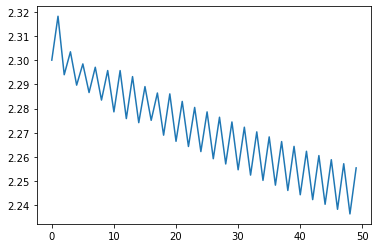

In [51]:
plt.figure()
plt.plot(loss_vec)
plt.show()

## MLP Evaluation

In [52]:
def evaluate(model):
#model = mlp
    predict_list = []
    correct = 0 
    for test_imgs, test_labels in test_loader:
        #print(test_imgs.shape)
        test_imgs = Variable(test_imgs).float()
        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        predict_list.append(predicted)
        correct += (predicted == test_labels).sum()
    print("Test accuracy:{:.3f}% ".format( float(correct)*100 / (len(test_loader)*BATCH_SIZE)))
predict = evaluate(mlp)

Test accuracy:4.500% 


<center><h2>Convolutional Neural Network</h2></center>

## Explanation

To better understand convolutional neural network I recommend the great section on it here : http://cs231n.github.io/convolutional-networks/

**Convolutional operation** : First let's clarify briefly how we can perform the convolutional operation on an image. For that we need to define a **kernel** which is a small matrix of size 5 \* 5 for example. To perform the convolution operation, we just need to slide the kernel along the image horizontally and vertically and do the dot product of the kernel and the small portion of the image.

**Pooling** : the convolutional operation give an output of the same size of the input image. To reduce the size of the image and thus reduce the number of paramers in the model we perform a Pooling operation. The pooling operation need a window size.. By sliding the window along the image, we compute the mean or the max of the portion of the image inside the window in case of MeanPooling or MaxPooling.

**Stride** is the number of pixels to pass at a time when sliding the convolutional kernel.  

**Padding** to preserve exactly the size of the input image, it is useful to add a zero padding on the border of the image. 


**To remember** : What makes a CNN so interesting for images is that it is invariant by translation and for each convolutional layer we only need to store the kernels. Thus we can stack a lot of layers to learn deep features without having too much parameters that would make a model untrainnable. 

## Data loader

Since a CNN needs a image shape as input let's reshape our flatten images to real image

In [53]:
torch_X_train = torch_X_train.view(-1, 1,300,300).float()
torch_X_test = torch_X_test.view(-1,1,300,300).float()
print(torch_X_train.shape)
print(torch_X_test.shape)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)


torch.Size([400, 1, 300, 300])
torch.Size([100, 1, 300, 300])


In [54]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32,64, kernel_size=7)
        #self.fc1 = nn.Linear(3*3*64,125)
        self.fc1 = nn.Linear(71*71*64,125)
        self.fc2 =nn.Linear(125,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        #print(x.shape)
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        #print(x.shape)
        x = F.dropout(x, p=0.5, training=self.training)
        #x = x.view(-1,64*3*3)
        x = x.view(-1,64*71*71)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
 
cnn = CNN()
print(cnn)

it = iter(train_loader)
X_batch, y_batch = next(it)
print(X_batch.shape)
print(cnn.forward(X_batch).shape)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  (fc1): Linear(in_features=322624, out_features=125, bias=True)
  (fc2): Linear(in_features=125, out_features=10, bias=True)
)
torch.Size([200, 1, 300, 300])
torch.Size([200, 10])


In [55]:
fit(cnn,train_loader)

Epoch : 0 [0/400 (0%)]	Loss: 2.302540	 Accuracy:10.500%
Epoch : 1 [0/400 (0%)]	Loss: 3.088841	 Accuracy:13.500%
Epoch : 2 [0/400 (0%)]	Loss: 2.580447	 Accuracy:7.500%
Epoch : 3 [0/400 (0%)]	Loss: 2.366047	 Accuracy:8.000%
Epoch : 4 [0/400 (0%)]	Loss: 2.321748	 Accuracy:9.500%
Epoch : 5 [0/400 (0%)]	Loss: 2.307357	 Accuracy:11.000%
Epoch : 6 [0/400 (0%)]	Loss: 2.308299	 Accuracy:10.500%
Epoch : 7 [0/400 (0%)]	Loss: 2.305162	 Accuracy:8.500%
Epoch : 8 [0/400 (0%)]	Loss: 2.305094	 Accuracy:11.000%
Epoch : 9 [0/400 (0%)]	Loss: 2.310176	 Accuracy:6.000%
Epoch : 10 [0/400 (0%)]	Loss: 2.303696	 Accuracy:10.000%
Epoch : 11 [0/400 (0%)]	Loss: 2.303548	 Accuracy:10.500%
Epoch : 12 [0/400 (0%)]	Loss: 2.304541	 Accuracy:8.500%
Epoch : 13 [0/400 (0%)]	Loss: 2.305947	 Accuracy:11.000%
Epoch : 14 [0/400 (0%)]	Loss: 2.304892	 Accuracy:11.000%
Epoch : 15 [0/400 (0%)]	Loss: 2.306222	 Accuracy:11.000%
Epoch : 16 [0/400 (0%)]	Loss: 2.305036	 Accuracy:11.000%
Epoch : 17 [0/400 (0%)]	Loss: 2.307370	 Accurac

[2.3025400638580322,
 3.6013381481170654,
 3.088841438293457,
 2.653294086456299,
 2.5804474353790283,
 2.4834156036376953,
 2.366046905517578,
 2.3364343643188477,
 2.3217484951019287,
 2.3018112182617188,
 2.307356834411621,
 2.305410623550415,
 2.3082988262176514,
 2.3009612560272217,
 2.305161952972412,
 2.301494836807251,
 2.3050944805145264,
 2.2989838123321533,
 2.310176134109497,
 2.300436496734619,
 2.3036956787109375,
 2.301287889480591,
 2.3035478591918945,
 2.3013558387756348,
 2.3045406341552734,
 2.3006529808044434,
 2.3059468269348145,
 2.301750898361206,
 2.304891586303711,
 2.300668239593506,
 2.306222438812256,
 2.2987353801727295,
 2.3050355911254883,
 2.29965877532959,
 2.3073699474334717,
 2.2971017360687256,
 2.3059237003326416,
 2.3002800941467285,
 2.30659818649292,
 2.2978475093841553,
 2.3025765419006348,
 2.3017077445983887,
 2.3051578998565674,
 2.300168514251709,
 2.3075265884399414,
 2.3020823001861572,
 2.305377960205078,
 2.295437812805176,
 2.3057739734

In [56]:
evaluate(cnn)

Test accuracy:5.000% 


In [57]:
output = cnn.forward(X_batch)
predicted = torch.max(output.data,1)[1]
print(output)
print(X_batch.shape)
print(output.shape)
print(predicted.shape)
print(predicted)

tensor([[-2.3304, -2.3367, -2.3565,  ..., -2.3434, -2.2599, -2.2286],
        [-2.3692, -2.3459, -2.3374,  ..., -2.3496, -2.2339, -2.2488],
        [-2.3138, -2.4164, -2.2477,  ..., -2.4108, -2.2152, -2.3073],
        ...,
        [-2.3304, -2.3367, -2.3565,  ..., -2.3434, -2.2599, -2.2286],
        [-2.3121, -2.4262, -2.2350,  ..., -2.4191, -2.2101, -2.3169],
        [-2.3133, -2.4196, -2.2436,  ..., -2.4134, -2.2135, -2.3104]],
       grad_fn=<LogSoftmaxBackward0>)
torch.Size([200, 1, 300, 300])
torch.Size([200, 10])
torch.Size([200])
tensor([9, 6, 3, 6, 3, 3, 9, 6, 6, 3, 3, 6, 3, 6, 9, 6, 8, 6, 9, 6, 3, 6, 6, 6,
        9, 3, 9, 3, 9, 6, 9, 6, 6, 6, 3, 6, 3, 6, 3, 6, 6, 6, 3, 6, 9, 9, 3, 9,
        2, 3, 3, 3, 6, 6, 6, 9, 9, 3, 3, 3, 3, 6, 3, 6, 3, 9, 3, 9, 9, 9, 9, 6,
        6, 3, 3, 9, 3, 6, 9, 6, 8, 6, 3, 3, 6, 9, 6, 6, 9, 9, 3, 6, 6, 6, 6, 6,
        6, 6, 3, 6, 6, 6, 9, 6, 9, 3, 6, 6, 9, 6, 3, 9, 3, 3, 9, 9, 6, 3, 6, 6,
        6, 3, 9, 9, 3, 6, 6, 6, 6, 3, 6, 6, 3, 6, 9, 6, 6

In [58]:
print(y_batch)

tensor([9, 3, 3, 9, 0, 8, 9, 2, 1, 5, 8, 0, 8, 1, 2, 1, 7, 6, 4, 0, 5, 2, 0, 8,
        2, 7, 2, 6, 2, 1, 5, 5, 7, 3, 3, 8, 9, 6, 1, 7, 9, 7, 7, 4, 4, 9, 5, 1,
        0, 0, 2, 1, 6, 1, 4, 7, 3, 0, 5, 8, 8, 4, 9, 1, 6, 1, 0, 4, 1, 2, 2, 6,
        8, 2, 8, 8, 7, 0, 5, 9, 7, 9, 3, 8, 4, 7, 6, 0, 8, 2, 8, 5, 3, 7, 7, 4,
        7, 4, 7, 2, 3, 7, 5, 0, 2, 9, 3, 3, 5, 5, 0, 7, 8, 8, 5, 6, 3, 2, 9, 0,
        3, 5, 6, 9, 2, 0, 1, 0, 7, 7, 9, 2, 4, 8, 8, 9, 1, 8, 9, 4, 1, 9, 9, 3,
        3, 6, 1, 2, 8, 0, 9, 1, 9, 2, 6, 1, 6, 1, 2, 7, 4, 8, 5, 2, 6, 4, 0, 2,
        9, 9, 1, 1, 5, 4, 0, 0, 7, 0, 9, 5, 4, 9, 5, 3, 3, 5, 4, 0, 6, 2, 1, 8,
        8, 4, 3, 0, 4, 0, 2, 0])


In [59]:
predicted = torch.max(output.data,1)[1]
print(predicted)

tensor([9, 6, 3, 6, 3, 3, 9, 6, 6, 3, 3, 6, 3, 6, 9, 6, 8, 6, 9, 6, 3, 6, 6, 6,
        9, 3, 9, 3, 9, 6, 9, 6, 6, 6, 3, 6, 3, 6, 3, 6, 6, 6, 3, 6, 9, 9, 3, 9,
        2, 3, 3, 3, 6, 6, 6, 9, 9, 3, 3, 3, 3, 6, 3, 6, 3, 9, 3, 9, 9, 9, 9, 6,
        6, 3, 3, 9, 3, 6, 9, 6, 8, 6, 3, 3, 6, 9, 6, 6, 9, 9, 3, 6, 6, 6, 6, 6,
        6, 6, 3, 6, 6, 6, 9, 6, 9, 3, 6, 6, 9, 6, 3, 9, 3, 3, 9, 9, 6, 3, 6, 6,
        6, 3, 9, 9, 3, 6, 6, 6, 6, 3, 6, 6, 3, 6, 9, 6, 6, 6, 6, 6, 3, 6, 3, 6,
        6, 9, 3, 6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 9, 6, 3, 6, 9,
        6, 3, 6, 6, 6, 3, 3, 6, 6, 9, 6, 6, 6, 6, 6, 3, 9, 6, 3, 6, 6, 6, 9, 9,
        9, 6, 6, 6, 6, 9, 3, 3])


In [60]:
a = torch.randn(6,3)
print(a)
torch.max(a,1)

tensor([[-0.5519, -0.1710, -0.5941],
        [-0.9214,  0.0469, -1.4235],
        [ 1.3684, -0.2784, -0.0394],
        [-1.8336, -0.9899, -0.9986],
        [-1.4077, -0.6611,  0.8281],
        [ 1.2974, -0.7229, -0.3476]])


torch.return_types.max(
values=tensor([-0.1710,  0.0469,  1.3684, -0.9899,  0.8281,  1.2974]),
indices=tensor([1, 1, 0, 1, 2, 0]))